# V2X 데이터 정보

In [2]:
import numpy as np
import cv2
import torch
import pandas as pd
import re
import pickle as pkl
import json
import glob
import shutil
import os
import json
import pathlib as pl
from typing import List, Tuple, Dict, Union, Optional
from tqdm import trange, tqdm
from glob import glob
from collections import Counter
from sklearn.model_selection import train_test_split

from modules.preprocessing import V2XPreprocessing
from modules.v2x import V2XData,V2XDataLabeled
from tsai.all import *
from tqdm import tqdm
from modules.RunTSAI import RunTSAI
from sklearn.utils import shuffle

data_path_8 = "/data/NIA50/50-1/data/v2xfinal/8월"
data_path_8s = "/data/NIA50/50-1/data/v2xfinal/8월s"
data_path_10 = "/data/NIA50/50-1/data/v2xfinal/9월"
data_path_10 = "/data/NIA50/50-1/data/v2xfinal/10월"
data_path_11 = "/data/NIA50/50-1/data/v2xfinal/11월"

## CSV, JSON 파일 경로 리스트 만들기
- CSV, JSON 파일을 한 경로에 담기
  - 8월
  -  ㄴ CSV
  -  ㄴ JSON
  - 9월
  -  ㄴ CSV
  -  ㄴ JSON

In [2]:
# 11월csv파일과 json파일을 각각 리스트로 가져옴
csv_files11, json_files11 = V2XPreprocessing.get_csv_data(data_path_11 + "/CSV"), \
                            V2XPreprocessing.get_json_data(data_path_11 + "/JSON")
print(f"csv file count: {len(csv_files11)}, json file count: {len(json_files11)}")

csv file count: 1350000, json file count: 1350000


In [3]:
# csv파일과 json파일 리스트를 pickle로 저장
with open("pickles/11월/CSV11.pkl", "wb") as f:
    pkl.dump(csv_files11, f)
with open("pickles/11월/JSON11.pkl", "wb") as f:
    pkl.dump(json_files11, f)

In [3]:
# csv파일과 json파일 각 리스트를 pickle로 가져옴
with open("pickles/11월/CSV11.pkl", "rb") as f:
    csv_files11 = pkl.load(f)
with open("pickles/11월/JSON11.pkl", "rb") as f:
    json_files11 = pkl.load(f)

In [5]:
# CSV파일 concat, pickle로 저장
df11csv = [pd.read_csv(f) for f in tqdm(csv_files11, desc="Reading csv files")]
df11csv = pd.concat(df11csv, ignore_index=True)
with open("pickles/11월/df11csv.pkl", "wb") as f:
    pkl.dump(df11csv, f)

Reading csv files: 100%|██████████| 450000/450000 [21:10<00:00, 354.06it/s] 


In [2]:
# CSV파일 concat pickle로 가져옴
with open("pickles/11월/df11csv.pkl", "rb") as f:
    df11csv = pkl.load(f)

In [3]:
df11csv.head()

,ISSUE_DATE,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE
0,20221101160930,FFE809A7,9228,126.879745,35.107718,315,0,80,0,bus
1,20221101160931,FFE809A7,9228,126.879745,35.107718,315,0,80,0,bus
2,20221101160932,FFE809A7,9228,126.879745,35.107718,315,0,80,0,bus
3,20221101160933,FFE809A7,9228,126.879745,35.107718,315,0,80,0,bus
4,20221101160934,FFE809A7,9228,126.879745,35.107718,315,0,80,0,bus


In [4]:
# NaN값 제거 후 NaN값이 있는지 확인
df11csv = df11csv.dropna()
# counts rows if there's NaN value
df11csv.isna().sum()

ISSUE_DATE       0
VEHICLE_ID       0
VEHICLE_CLASS    0
LONGITUDE        0
LATITUDE         0
HEADING          0
SPEED            0
BRAKE_STATUS     0
ACC_SEC          0
VEHICLE_TYPE     0
dtype: int64

In [5]:
df11csv.shape

(4500001, 10)

In [8]:
df11csv

,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE
0,FFE809A7,9228,126.879745,35.107718,315,0,80,0,bus
1,FFE809A7,9228,126.879745,35.107718,315,0,80,0,bus
2,FFE809A7,9228,126.879745,35.107718,315,0,80,0,bus
3,FFE809A7,9228,126.879745,35.107718,315,0,80,0,bus
4,FFE809A7,9228,126.879745,35.107718,315,0,80,0,bus
...,...,...,...,...,...,...,...,...,...
4500421,FFE81227,9228,126.921205,35.143929,20,24,78,-139,bus
4500422,FFE81227,9228,126.921229,35.143985,20,21,78,-111,bus
4500423,FFE81227,9228,126.921246,35.144026,20,13,78,-222,bus
4500424,FFE81227,9228,126.921256,35.14405,20,6,78,-167,bus


In [10]:
# int or float type이 아닌 값이 있는지 확인
for col in df11csv.columns:
    if col in ["ISSUE_DATE"]:
        df11csv.drop(col, axis=1, inplace=True)
        continue
    if col in ["VEHICLE_ID", "VEHICLE_TYPE"]:
        continue
    # print if value is not float or int
    print(f"{col}: {df11csv[col].apply(lambda x: type(x) not in [float, int]).sum()}")

VEHICLE_CLASS: 0
LONGITUDE: 0
LATITUDE: 0
HEADING: 0
SPEED: 0
BRAKE_STATUS: 0
ACC_SEC: 0


In [9]:
# exclude ["ISSUE_DATE"] column, values to int on ["VEHICLE_CLASS", "HEADING"], str on ["VEHICLE_ID", "VEHICLE_TYPE"], float on others

for col in df11csv.columns:
    if col in ["VEHICLE_CLASS", "HEADING"]:
        df11csv[col] = df11csv[col].astype(int)
    elif col in ["VEHICLE_ID", "VEHICLE_TYPE"]:
        df11csv[col] = df11csv[col].astype(str)
    else:
        df11csv[col] = df11csv[col].astype(float)

In [11]:
# value counts of VEHICLE_ID VEHICLE_CLASS VEHICLE_TYPE
for col in df11csv.columns:
    if col in ["VEHICLE_ID", "VEHICLE_CLASS", "VEHICLE_TYPE"]:
        print(f"{col}: {df11csv[col].value_counts()}")
        print(f"{col} unique: {df11csv[col].unique().shape}", end="\n\n")

VEHICLE_ID: FFE80C29    7800
FFE80D78    7800
FFE809D0    7600
FFE80A6F    7600
FFE80D0C    7600
            ... 
FFE8111E     200
FFE8112B     200
FFE80EA3     200
FFE80ED3     200
FFE80E3A     200
Name: VEHICLE_ID, Length: 1559, dtype: int64
VEHICLE_ID unique: (1559,)

VEHICLE_CLASS: 9228    3458293
9220     934908
9741      40000
9230      30400
9736      27400
9240       6200
9734       2800
Name: VEHICLE_CLASS, dtype: int64
VEHICLE_CLASS unique: (7,)

VEHICLE_TYPE: bus        3457973
car         934850
special     106787
none           391
Name: VEHICLE_TYPE, dtype: int64
VEHICLE_TYPE unique: (4,)



In [12]:
# categorize ["VEHICLE_ID", "VEHICLE_CLASS", "VEHICLE_TYPE"] columns
from sklearn.preprocessing import LabelEncoder

for col in df11csv.columns:
    if col in ["VEHICLE_ID", "VEHICLE_CLASS", "VEHICLE_TYPE"]:
        encoder = LabelEncoder()
        encoder.fit(df11csv[col])
        categorized_array = encoder.transform(df11csv[col])
        print(categorized_array)
        df11csv[col] = categorized_array

[  10   10   10 ... 1558 1558 1558]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]


In [14]:
# index reset
df11csv.reset_index(drop=True, inplace=True)

# remove row 4500000
df11csv.drop(4500000, axis=0, inplace=True)
df11csv

,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE
0,10,1,126.879745,35.107718,315,0.0,80.0,0.0,0
1,10,1,126.879745,35.107718,315,0.0,80.0,0.0,0
2,10,1,126.879745,35.107718,315,0.0,80.0,0.0,0
3,10,1,126.879745,35.107718,315,0.0,80.0,0.0,0
4,10,1,126.879745,35.107718,315,0.0,80.0,0.0,0
...,...,...,...,...,...,...,...,...,...
4499995,1558,1,126.921175,35.143863,20,31.0,78.0,-83.0,0
4499996,1558,1,126.921205,35.143929,20,24.0,78.0,-139.0,0
4499997,1558,1,126.921229,35.143985,20,21.0,78.0,-111.0,0
4499998,1558,1,126.921246,35.144026,20,13.0,78.0,-222.0,0


# Standarization

In [15]:
# standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df11csv_scaled = scaler.fit_transform(df11csv)
df11csv_scaled = pd.DataFrame(df11csv_scaled, columns=df11csv.columns)
df11csv_scaled

,VEHICLE_ID,VEHICLE_CLASS,LONGITUDE,LATITUDE,HEADING,SPEED,BRAKE_STATUS,ACC_SEC,VEHICLE_TYPE
0,-1.590894,0.175411,0.018140,-0.105334,1.355284,-0.810118,1.124432,-0.003161,-0.476041
1,-1.590894,0.175411,0.018140,-0.105334,1.355284,-0.810118,1.124432,-0.003161,-0.476041
2,-1.590894,0.175411,0.018140,-0.105335,1.355284,-0.810118,1.124432,-0.003161,-0.476041
3,-1.590894,0.175411,0.018140,-0.105335,1.355284,-0.810118,1.124432,-0.003161,-0.476041
4,-1.590894,0.175411,0.018140,-0.105335,1.355284,-0.810118,1.124432,-0.003161,-0.476041
...,...,...,...,...,...,...,...,...,...
4499995,2.064391,0.175411,0.042592,-0.028860,-1.337414,0.771787,1.073464,-1.645776,-0.476041
4499996,2.064391,0.175411,0.042610,-0.028720,-1.337414,0.414582,1.073464,-2.754047,-0.476041
4499997,2.064391,0.175411,0.042624,-0.028602,-1.337414,0.261495,1.073464,-2.199911,-0.476041
4499998,2.064391,0.175411,0.042635,-0.028516,-1.337414,-0.146739,1.073464,-4.396662,-0.476041


# CSV 파일 Dataframe pickle로 저장

In [16]:
with open("pickles/11월/df11_scaled.pkl", "wb") as f:
    pkl.dump(df11csv_scaled, f)

In [17]:
df11csv_scaled = pd.read_pickle("pickles/11월/df11_scaled.pkl") # load pickle

In [18]:
# reshape 1350000 rows × 9 columns to 1350000 rows x 9 columns x 10, and changed to numpy array
df11csv_scaled_npy = df11csv_scaled.values.reshape(df11csv_scaled.shape[0]//10, 10, 9)
df11csv_scaled_npy = df11csv_scaled_npy.transpose(0, 2, 1)

In [19]:
# save numpy array as npy file
np.save("pickles/11월/X_11.npy", df11csv_scaled_npy)

In [20]:
print(df11csv_scaled_npy.shape)
df11csv_scaled_npy[:2]

(450000, 9, 10)


array([[[-1.59089447, -1.59089447, -1.59089447, -1.59089447,
         -1.59089447, -1.59089447, -1.59089447, -1.59089447,
         -1.59089447, -1.59089447],
        [ 0.1754109 ,  0.1754109 ,  0.1754109 ,  0.1754109 ,
          0.1754109 ,  0.1754109 ,  0.1754109 ,  0.1754109 ,
          0.1754109 ,  0.1754109 ],
        [ 0.01814007,  0.01814007,  0.01814001,  0.01814001,
          0.01814001,  0.0181399 ,  0.0181399 ,  0.0181399 ,
          0.01813978,  0.01813978],
        [-0.10533418, -0.10533439, -0.10533481, -0.10533481,
         -0.10533523, -0.10533523, -0.10533545, -0.10533587,
         -0.10533587, -0.10533629],
        [ 1.35528426,  1.35528426,  1.35528426,  1.35528426,
          1.35528426,  1.35528426,  1.35528426,  1.35528426,
          1.35528426,  1.35528426],
        [-0.81011827, -0.81011827, -0.81011827, -0.81011827,
         -0.81011827, -0.81011827, -0.81011827, -0.81011827,
         -0.81011827, -0.81011827],
        [ 1.12443212,  1.12443212,  1.12443212,  1.1

----------------------

# JSON

In [3]:
with open("pickles/11월/JSON11.pkl", "rb") as f:
    json_files11 = pkl.load(f)

In [4]:
# json info
with open(json_files11[0], "r") as f:
    json_sample = json.load(f)
json_sample

{'Path': 'V_221101_C_A_FFE809A7_000349.csv',
 'Annotation': {'Vehicle_ID': 'FFE809A7',
  'Turn': 'False',
  'Lane': 'False',
  'Speed': 'False',
  'Hazard': 'False'}}

In [59]:
df11_json = pd.read_json(json_files11[0])
# df8_json = df8_json['Annotation'][['Turn', 'Lane', 'Speed', 'Hazard']].to_frame().T
# values = df8_json.values.tolist()[0]
# values
df11_json

,Path,Annotation
Hazard,V_220801_C_A_FFE809B4_000075.csv,False
Lane,V_220801_C_A_FFE809B4_000075.csv,False
Speed,V_220801_C_A_FFE809B4_000075.csv,False
Turn,V_220801_C_A_FFE809B4_000075.csv,False
Vehicle_ID,V_220801_C_A_FFE809B4_000075.csv,FFE809B4


In [5]:
json11_list = []
cols = ['Turn', 'Lane', 'Speed', 'Hazard']
print(cols)

df8json = pd.DataFrame(columns=cols)
for i in trange(len(json_files11)):
    with open(json_files11[i], "r") as f:
        try:
            temp_json = json.load(f)
            temp_json = [temp_json['Annotation'][key] for key in temp_json['Annotation'].keys() if key in cols]
            json11_list.append(temp_json)
        
        except Exception as e:
            print(f"{json_files11[i]} error: {e}")
            continue
        
# json8_list = [x[:4] for x in json8_list]
json11_npy = np.array(json11_list)
np.save("pickles/11월/y_11.npy", json11_npy)


['Turn', 'Lane', 'Speed', 'Hazard']


100%|██████████| 450000/450000 [11:08<00:00, 672.93it/s]


In [6]:
json11_npy = np.load("pickles/11월/y_11.npy")
json11_npy.shape

(450000, 4)

In [7]:
json11_npy

array([['False', 'False', 'False', 'False'],
       ['False', 'False', 'False', 'False'],
       ['False', 'False', 'False', 'False'],
       ...,
       ['False', 'False', 'False', 'False'],
       ['False', 'False', 'False', 'False'],
       ['False', 'False', 'False', 'False']], dtype='<U7')

# Time series classification

In [5]:
X = np.load("pickles/11월/X_11.npy")
y = np.load("pickles/11월/y_11.npy")

###
from collections import Counter
print("turn:", np.unique(y[:, 0]))
print("lane:", np.unique(y[:, 1]))
print("speed:", np.unique(y[:, 2]))
print("hazard:", np.unique(y[:, 3]))
print("turn:", Counter(y[:, 0]))
print("lane:", Counter(y[:, 1]))
print("speed:", Counter(y[:, 2]))
print("hazard:", Counter(y[:, 3]))

turn: ['Fals' 'Left' 'Reve' 'Righ']
lane: ['Fals']
speed: ['Acc' 'Fals' 'Hbrk']
hazard: ['Fals' 'True']
turn: Counter({'Fals': 1274127, 'Righ': 38008, 'Left': 35376, 'Reve': 2489})
lane: Counter({'Fals': 1350000})
speed: Counter({'Fals': 1348923, 'Hbrk': 796, 'Acc': 281})
hazard: Counter({'Fals': 1345730, 'True': 4270})


In [12]:
get_splits()

array(['Fals', 'Fals', 'Fals', ..., 'Fals', 'Fals', 'Fals'], dtype='<U4')

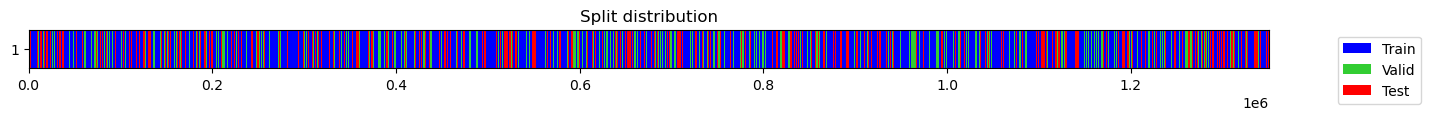

In [13]:
from tsai.all import *
config = AttrDict(
    batch_tfms = TSStandardize(by_sample=True),
    arch_config = {},
    architecture = LSTM, # LSTM, MLSTM_Plus
    lr = 1e-3,
    n_epochs = 200,
)

X = np.load("pickles/11월/X_11.npy")
y = np.load("pickles/11월/y_11.npy")
split_all = get_splits(y[:,0], shuffle=True, valid_size=0.2, test_size=0.2, random_state=42)
split = split_all

In [14]:
test_eq(X.shape, (X.shape[0], 9, 10))
test_eq(y.shape, (X.shape[0], 4))

In [15]:
tfms = [None, [MultiCategorize, OneHotEncode]]
dsets = TSDatasets(X, y, tfms=tfms, splits=split)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], shuffle_train=False, batch_tfms=[TSStandardize()])

model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=[accuracy_multi, precision_multi, F1_multi])
learn.fit_one_cycle(10)
learn.recorder.plot_loss()

-------------------